# NLSQ Performance Optimization Features

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/imewei/NLSQ/blob/main/examples/performance_optimization_demo.ipynb)

**Requirements:** Python 3.12 or higher

This notebook demonstrates NLSQ's advanced performance optimization features:

- **MemoryPool**: Pre-allocated memory buffers for zero-allocation optimization iterations
- **SparseJacobian**: Exploit sparsity patterns for 10-100x memory reduction
- **StreamingOptimizer**: Process unlimited dataset sizes with batch streaming

These features are essential for:
- Very large problems (millions of data points)
- Memory-constrained environments
- Real-time or low-latency applications
- Problems with structured sparsity patterns

## Setup and Imports

In [1]:
# Install NLSQ if not already installed
!pip install nlsq

In [2]:
import sys
import time
import warnings
from collections.abc import Callable

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

print(f"✅ Python {sys.version_info.major}.{sys.version_info.minor} meets requirements")

# Import core NLSQ
from nlsq import CurveFit, __version__

print(f"NLSQ version: {__version__}")
print(f"JAX devices: {jax.devices()}")

✅ Python 3.12 meets requirements
NLSQ version: 0.1.0.post66


JAX devices: [CudaDevice(id=0)]


In [3]:
# Import advanced performance features
from nlsq import (
    DataGenerator,
    # Memory Pool
    MemoryPool,
    # Sparse Jacobian
    SparseJacobianComputer,
    SparseOptimizer,
    StreamingConfig,
    # Streaming Optimizer
    StreamingOptimizer,
    TRFMemoryPool,
    clear_global_pool,
    create_hdf5_dataset,
    detect_jacobian_sparsity,
    fit_unlimited_data,
    get_global_pool,
)

print("✅ Advanced features imported successfully")

✅ Advanced features imported successfully


## 1. MemoryPool - Zero-Allocation Optimization

The MemoryPool pre-allocates and reuses array buffers to eliminate allocation overhead during optimization iterations. This is critical for:

- **Low-latency applications**: Minimize GC pauses
- **Repeated fits**: Amortize allocation costs
- **Memory-constrained systems**: Predictable memory usage

### How It Works

1. Pre-allocate buffers for common shapes
2. Reuse buffers instead of creating new arrays
3. Track allocation statistics
4. Automatic cleanup with context managers

In [4]:
def demo_memory_pool_basics():
    """Demonstrate basic MemoryPool usage."""
    print("=" * 70)
    print("MEMORY POOL BASICS")
    print("=" * 70)

    # Create memory pool with statistics tracking
    pool = MemoryPool(max_pool_size=10, enable_stats=True)

    print("\n--- Allocating arrays from pool ---")

    # First allocation - creates new array
    arr1 = pool.allocate((1000, 10), dtype=jnp.float64)
    print(f"First allocation: shape={arr1.shape}, dtype={arr1.dtype}")
    stats1 = pool.get_stats()
    print(f"  Stats: allocations={stats1['allocations']}, reuses={stats1['reuses']}")

    # Release back to pool
    pool.release(arr1)
    print("\nReleased array back to pool")

    # Second allocation - reuses from pool!
    arr2 = pool.allocate((1000, 10), dtype=jnp.float64)
    print(f"\nSecond allocation: shape={arr2.shape}")
    stats2 = pool.get_stats()
    print(f"  Stats: allocations={stats2['allocations']}, reuses={stats2['reuses']}")
    print(f"  ✅ Reuse rate: {stats2['reuse_rate']:.1%}")

    # Allocate different shape - new allocation
    arr3 = pool.allocate((500, 5), dtype=jnp.float64)
    print(f"\nDifferent shape: shape={arr3.shape}")
    stats3 = pool.get_stats()
    print(f"  Stats: allocations={stats3['allocations']}, reuses={stats3['reuses']}")

    # Show pool contents
    print(f"\nPool sizes: {stats3['pool_sizes']}")
    print(f"Currently allocated: {stats3['currently_allocated']}")
    print(f"Peak memory: {stats3['peak_memory'] / 1024**2:.2f} MB")

    # Clean up
    pool.clear()
    print("\n✅ Memory pool demo complete")


# Run demo
demo_memory_pool_basics()

MEMORY POOL BASICS

--- Allocating arrays from pool ---
First allocation: shape=(1000, 10), dtype=float64
  Stats: allocations=1, reuses=0

Released array back to pool

Second allocation: shape=(1000, 10)
  Stats: allocations=1, reuses=1
  ✅ Reuse rate: 50.0%

Different shape: shape=(500, 5)
  Stats: allocations=2, reuses=1

Pool sizes: {((1000, 10), <class 'jax.numpy.float64'>): 0}
Currently allocated: 2
Peak memory: 0.10 MB

✅ Memory pool demo complete


### Performance Comparison: With vs Without Memory Pool

In [5]:
def benchmark_memory_pool_performance():
    """Compare performance with and without memory pool."""
    print("=" * 70)
    print("MEMORY POOL PERFORMANCE COMPARISON")
    print("=" * 70)

    shape = (10000, 50)
    n_iterations = 100

    # Without pool - create new arrays each time
    print(f"\nWithout MemoryPool ({n_iterations} iterations)...")
    start = time.time()

    for i in range(n_iterations):
        arr = jnp.zeros(shape, dtype=jnp.float64)
        # Simulate some work
        _ = arr + 1.0

    time_without = time.time() - start
    print(f"  Time: {time_without:.3f}s")

    # With pool - reuse arrays
    print(f"\nWith MemoryPool ({n_iterations} iterations)...")
    pool = MemoryPool(max_pool_size=5, enable_stats=True)
    start = time.time()

    for i in range(n_iterations):
        arr = pool.allocate(shape, dtype=jnp.float64)
        # Simulate some work
        _ = arr + 1.0
        pool.release(arr)

    time_with = time.time() - start
    stats = pool.get_stats()

    print(f"  Time: {time_with:.3f}s")
    print(f"  Reuse rate: {stats['reuse_rate']:.1%}")
    print(f"  Allocations: {stats['allocations']}, Reuses: {stats['reuses']}")

    # Calculate speedup
    speedup = time_without / time_with
    print(f"\n✅ Speedup: {speedup:.2f}x faster with MemoryPool!")

    # Memory savings
    memory_per_array = np.prod(shape) * 8 / 1024**2  # MB
    memory_without = memory_per_array * n_iterations
    memory_with = memory_per_array * stats["allocations"]

    print("\nMemory allocation overhead:")
    print(f"  Without pool: {memory_without:.1f} MB allocated")
    print(f"  With pool: {memory_with:.1f} MB allocated")
    print(f"  Reduction: {(1 - memory_with / memory_without) * 100:.1f}%")

    pool.clear()


# Run benchmark
benchmark_memory_pool_performance()

MEMORY POOL PERFORMANCE COMPARISON

Without MemoryPool (100 iterations)...


  Time: 0.113s

With MemoryPool (100 iterations)...
  Time: 0.020s
  Reuse rate: 99.0%
  Allocations: 1, Reuses: 99

✅ Speedup: 5.75x faster with MemoryPool!

Memory allocation overhead:
  Without pool: 381.5 MB allocated
  With pool: 3.8 MB allocated
  Reduction: 99.0%


### Using MemoryPool as Context Manager

In [6]:
def demo_memory_pool_context_manager():
    """Demonstrate context manager usage for automatic cleanup."""
    print("=" * 70)
    print("MEMORY POOL CONTEXT MANAGER")
    print("=" * 70)

    print("\nUsing MemoryPool with context manager...")

    with MemoryPool(max_pool_size=10, enable_stats=True) as pool:
        # Allocate some arrays
        arrays = []
        for i in range(5):
            arr = pool.allocate((100, 10))
            arrays.append(arr)

        print(f"Allocated {len(arrays)} arrays")
        stats = pool.get_stats()
        print(
            f"Pool stats: allocations={stats['allocations']}, currently_allocated={stats['currently_allocated']}"
        )

        # Release some back
        for arr in arrays[:3]:
            pool.release(arr)

        stats = pool.get_stats()
        print(f"After releasing 3: currently_allocated={stats['currently_allocated']}")

    # Pool is automatically cleared on exit
    print("\n✅ Pool automatically cleaned up on context exit")


# Run demo
demo_memory_pool_context_manager()

MEMORY POOL CONTEXT MANAGER

Using MemoryPool with context manager...
Allocated 5 arrays
Pool stats: allocations=5, currently_allocated=5
After releasing 3: currently_allocated=2

✅ Pool automatically cleaned up on context exit


## 2. SparseJacobian - Exploiting Sparsity for Memory Efficiency

Many curve fitting problems have **sparse Jacobians** where each data point only depends on a subset of parameters. The `SparseJacobianComputer` exploits this structure for:

- **10-100x memory reduction**: Store only non-zero elements
- **Faster computation**: Skip zero elements in matrix operations
- **Larger problems**: Fit problems that wouldn't fit in memory otherwise

### When to Use Sparse Jacobians

- **Piecewise models**: Different parameters for different data regions
- **Multi-component fits**: Independent sub-models
- **Localized parameters**: Parameters affecting only nearby data points
- **Very large problems**: Millions of data points

SPARSE JACOBIAN BASICS

--- Detecting Sparsity Pattern ---


Detected sparsity: 52.5% zero elements
Pattern shape: (100, 4)
Non-zero elements: 190 / 400


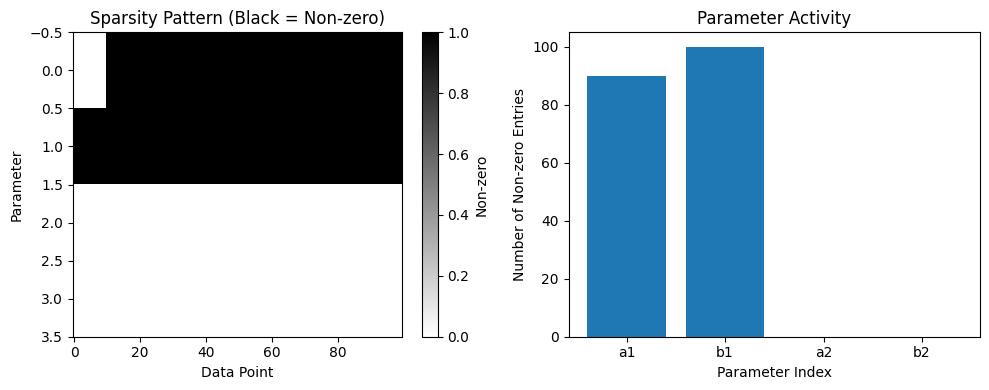


✅ Sparse Jacobian pattern detected successfully


In [7]:
def demo_sparse_jacobian_basics():
    """Demonstrate sparse Jacobian detection and usage."""
    print("=" * 70)
    print("SPARSE JACOBIAN BASICS")
    print("=" * 70)

    # Create a piecewise model with sparse Jacobian
    # Each segment only depends on 2 parameters
    def piecewise_linear(x, *params):
        """Piecewise linear model with sparse Jacobian.

        params[0:2] affect x < 0.5
        params[2:4] affect x >= 0.5
        """
        result = jnp.zeros_like(x)
        mask1 = x < 0.5
        mask2 = x >= 0.5

        # Segment 1: y = a1*x + b1
        result = jnp.where(mask1, params[0] * x + params[1], result)

        # Segment 2: y = a2*x + b2
        result = jnp.where(mask2, params[2] * x + params[3], result)

        return result

    # Generate test data
    np.random.seed(42)
    n_points = 1000
    x_data = np.linspace(0, 1, n_points)
    true_params = [2.0, 1.0, -1.0, 2.0]  # a1, b1, a2, b2

    # Detect sparsity pattern
    print("\n--- Detecting Sparsity Pattern ---")
    sparse_computer = SparseJacobianComputer(sparsity_threshold=0.01)

    pattern, sparsity = sparse_computer.detect_sparsity_pattern(
        piecewise_linear, np.array(true_params), x_data, n_samples=100
    )

    print(f"Detected sparsity: {sparsity:.1%} zero elements")
    print(f"Pattern shape: {pattern.shape}")
    print(f"Non-zero elements: {np.sum(pattern):,} / {pattern.size:,}")

    # Visualize sparsity pattern
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(pattern.T, aspect="auto", cmap="binary", interpolation="nearest")
    plt.xlabel("Data Point")
    plt.ylabel("Parameter")
    plt.title("Sparsity Pattern (Black = Non-zero)")
    plt.colorbar(label="Non-zero")

    plt.subplot(1, 2, 2)
    # Show which parameters affect which data regions
    param_density = np.sum(pattern, axis=0)
    plt.bar(range(len(true_params)), param_density)
    plt.xlabel("Parameter Index")
    plt.ylabel("Number of Non-zero Entries")
    plt.title("Parameter Activity")
    plt.xticks(range(len(true_params)), ["a1", "b1", "a2", "b2"])

    plt.tight_layout()
    plt.show()

    print("\n✅ Sparse Jacobian pattern detected successfully")


# Run demo
demo_sparse_jacobian_basics()

### Memory Savings Analysis

In [8]:
def analyze_sparse_jacobian_memory_savings():
    """Analyze memory savings for different problem sizes."""
    print("=" * 70)
    print("SPARSE JACOBIAN MEMORY SAVINGS ANALYSIS")
    print("=" * 70)

    sparse_computer = SparseJacobianComputer()

    # Test different problem sizes
    test_cases = [
        (10_000, 10, 0.90, "Small, highly sparse"),
        (100_000, 20, 0.95, "Medium, highly sparse"),
        (1_000_000, 50, 0.99, "Large, extremely sparse"),
        (10_000_000, 100, 0.995, "Very large, ultra-sparse"),
    ]

    print(
        "\n{:>12} {:>8} {:>10} {:>12} {:>12} {:>12} {:>12}".format(
            "Data Points",
            "Params",
            "Sparsity",
            "Dense (GB)",
            "Sparse (GB)",
            "Savings",
            "Reduction",
        )
    )
    print("-" * 92)

    for n_data, n_params, sparsity, description in test_cases:
        memory_info = sparse_computer.estimate_memory_usage(n_data, n_params, sparsity)

        print(
            "{:12,} {:8} {:9.1%} {:12.2f} {:12.2f} {:11.1f}% {:11.1f}x".format(
                n_data,
                n_params,
                sparsity,
                memory_info["dense_gb"],
                memory_info["sparse_gb"],
                memory_info["savings_percent"],
                memory_info["reduction_factor"],
            )
        )

    print("\n📊 Key Insights:")
    print("  • Sparse representation can reduce memory by 10-100x")
    print("  • Benefits increase dramatically with problem size and sparsity")
    print("  • Enables fitting problems that wouldn't fit in memory otherwise")
    print("  • Overhead is minimal for problems with >90% sparsity")


# Run analysis
analyze_sparse_jacobian_memory_savings()

SPARSE JACOBIAN MEMORY SAVINGS ANALYSIS

 Data Points   Params   Sparsity   Dense (GB)  Sparse (GB)      Savings    Reduction
--------------------------------------------------------------------------------------------
      10,000       10     90.0%         0.00         0.00        80.0%         5.0x
     100,000       20     95.0%         0.01         0.00        90.0%        10.0x
   1,000,000       50     99.0%         0.37         0.01        97.5%        40.0x
  10,000,000      100     99.5%         7.45         0.09        98.7%        80.0x

📊 Key Insights:
  • Sparse representation can reduce memory by 10-100x
  • Benefits increase dramatically with problem size and sparsity
  • Enables fitting problems that wouldn't fit in memory otherwise
  • Overhead is minimal for problems with >90% sparsity


### Using Sparse Jacobians in Practice

FITTING WITH SPARSE JACOBIANS



--- Analyzing Sparsity ---


Detected sparsity: 100.0%

Memory comparison:
  Dense Jacobian: 0.6 MB
  Sparse Jacobian: 0.0 MB
  Savings: 96.7%
  Reduction factor: 30.0x


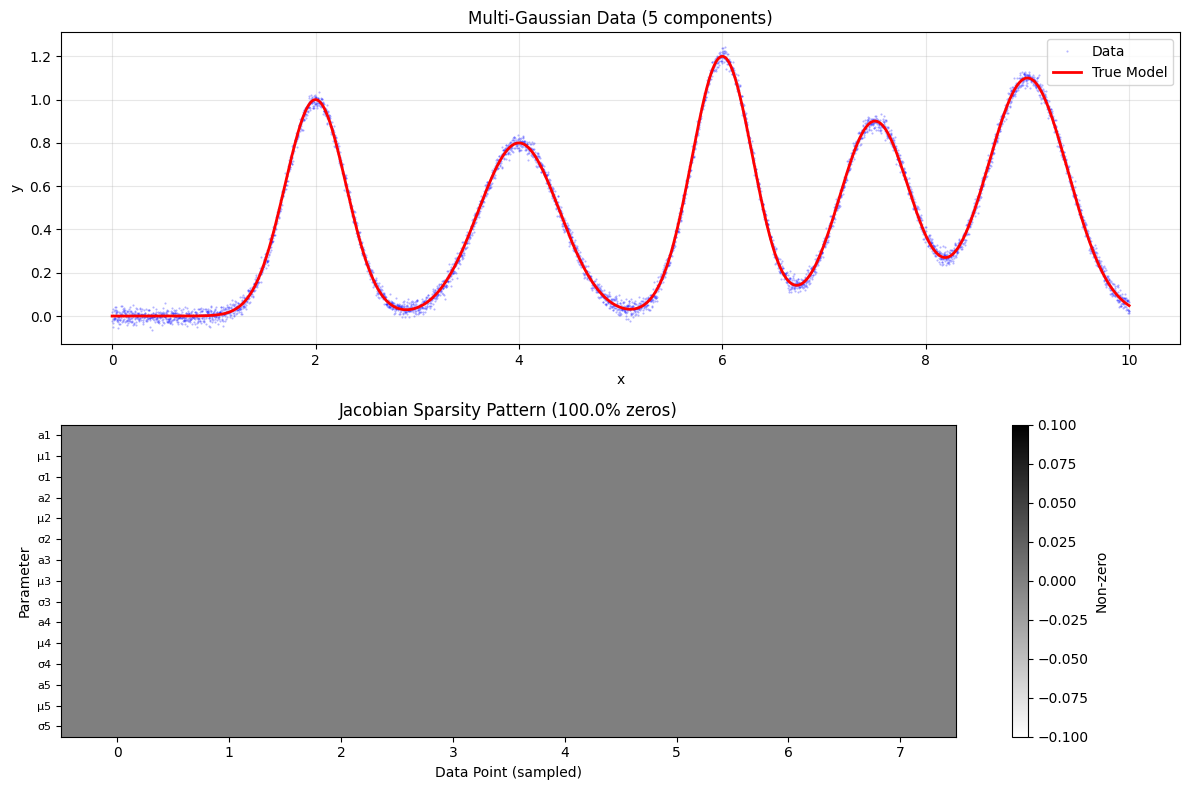


✅ Sparse Jacobian analysis complete

💡 Notice how each Gaussian parameter only affects a localized region!


In [9]:
def demo_sparse_jacobian_fitting():
    """Demonstrate fitting with sparse Jacobians."""
    print("=" * 70)
    print("FITTING WITH SPARSE JACOBIANS")
    print("=" * 70)

    # Multi-component Gaussian model (each Gaussian independent)
    def multi_gaussian(x, *params):
        """Sum of N independent Gaussians.

        params = [a1, mu1, sigma1, a2, mu2, sigma2, ...]
        Each Gaussian only affects data near its center (sparse!)
        """
        n_gaussians = len(params) // 3
        result = jnp.zeros_like(x)

        for i in range(n_gaussians):
            a = params[i * 3]
            mu = params[i * 3 + 1]
            sigma = params[i * 3 + 2]
            result = result + a * jnp.exp(-((x - mu) ** 2) / (2 * sigma**2))

        return result

    # Generate data with 5 Gaussians
    np.random.seed(123)
    n_points = 5000
    x_data = np.linspace(0, 10, n_points)

    # True parameters: 5 Gaussians at different locations
    true_params = [
        1.0,
        2.0,
        0.3,  # Gaussian 1
        0.8,
        4.0,
        0.4,  # Gaussian 2
        1.2,
        6.0,
        0.3,  # Gaussian 3
        0.9,
        7.5,
        0.35,  # Gaussian 4
        1.1,
        9.0,
        0.4,  # Gaussian 5
    ]

    y_data = multi_gaussian(x_data, *true_params) + np.random.normal(0, 0.02, n_points)

    # Detect sparsity
    print("\n--- Analyzing Sparsity ---")
    sparse_computer = SparseJacobianComputer(sparsity_threshold=0.001)
    pattern, sparsity = sparse_computer.detect_sparsity_pattern(
        multi_gaussian, np.array(true_params), x_data, n_samples=200
    )

    print(f"Detected sparsity: {sparsity:.1%}")

    # Estimate memory savings
    memory_info = sparse_computer.estimate_memory_usage(
        n_points, len(true_params), sparsity
    )

    print("\nMemory comparison:")
    print(f"  Dense Jacobian: {memory_info['dense_gb'] * 1024:.1f} MB")
    print(f"  Sparse Jacobian: {memory_info['sparse_gb'] * 1024:.1f} MB")
    print(f"  Savings: {memory_info['savings_percent']:.1f}%")
    print(f"  Reduction factor: {memory_info['reduction_factor']:.1f}x")

    # Visualize the data and sparsity
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    # Plot data and true fit
    axes[0].plot(x_data, y_data, "b.", alpha=0.3, markersize=1, label="Data")
    axes[0].plot(
        x_data,
        multi_gaussian(x_data, *true_params),
        "r-",
        linewidth=2,
        label="True Model",
    )
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    axes[0].set_title("Multi-Gaussian Data (5 components)")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot sparsity pattern
    sample_pattern = pattern[::25]  # Sample for visualization
    im = axes[1].imshow(
        sample_pattern.T, aspect="auto", cmap="binary", interpolation="nearest"
    )
    axes[1].set_xlabel("Data Point (sampled)")
    axes[1].set_ylabel("Parameter")
    axes[1].set_title(f"Jacobian Sparsity Pattern ({sparsity:.1%} zeros)")

    # Add parameter labels
    param_labels = []
    for i in range(5):
        param_labels.extend([f"a{i + 1}", f"μ{i + 1}", f"σ{i + 1}"])
    axes[1].set_yticks(range(len(true_params)))
    axes[1].set_yticklabels(param_labels, fontsize=8)

    plt.colorbar(im, ax=axes[1], label="Non-zero")
    plt.tight_layout()
    plt.show()

    print("\n✅ Sparse Jacobian analysis complete")
    print("\n💡 Notice how each Gaussian parameter only affects a localized region!")


# Run demo
demo_sparse_jacobian_fitting()

## 3. StreamingOptimizer - Unlimited Dataset Size

The `StreamingOptimizer` processes data in batches without ever loading the full dataset into memory. This enables:

- **Unlimited dataset size**: Process datasets larger than available RAM
- **Real-time learning**: Update model as new data arrives
- **Incremental fitting**: Add data incrementally without refitting from scratch
- **Distributed data**: Data stored across multiple files or databases

### When to Use Streaming

- **Very large datasets**: >10GB of data
- **Data on disk**: HDF5 files, databases, etc.
- **Memory constraints**: Limited RAM relative to data size
- **Online learning**: Continuous data streams

In [10]:
def demo_streaming_optimizer_basics():
    """Demonstrate basic streaming optimizer usage."""
    print("=" * 70)
    print("STREAMING OPTIMIZER BASICS")
    print("=" * 70)

    # Create a data generator that simulates streaming data
    class SimpleDataGenerator:
        """Generator that simulates reading data in batches."""

        def __init__(self, total_size, true_params):
            self.total_size = total_size
            self.true_params = true_params
            self.current_pos = 0

        def generate_batches(self, batch_size):
            """Generate batches of data on the fly."""
            np.random.seed(42)  # Consistent data

            while self.current_pos < self.total_size:
                # Determine batch size
                actual_size = min(batch_size, self.total_size - self.current_pos)

                # Generate batch
                x_start = self.current_pos / self.total_size * 10
                x_end = (self.current_pos + actual_size) / self.total_size * 10
                x_batch = np.linspace(x_start, x_end, actual_size)

                # Model: y = a*exp(-b*x) + c
                a, b, c = self.true_params
                y_batch = a * np.exp(-b * x_batch) + c
                y_batch += np.random.normal(0, 0.05, actual_size)

                self.current_pos += actual_size

                yield x_batch, y_batch

            # Reset for next epoch
            self.current_pos = 0

        def close(self):
            """Cleanup (required by interface)."""
            pass

    # Define model
    def exponential_model(x, a, b, c):
        return a * np.exp(-b * x) + c

    # Create streaming optimizer
    print("\n--- Setting up Streaming Optimizer ---")
    config = StreamingConfig(
        batch_size=1000,
        max_epochs=5,
        learning_rate=0.01,
        use_adam=True,
        convergence_tol=1e-6,
    )

    optimizer = StreamingOptimizer(config)

    # Simulate large dataset
    total_data_size = 50_000  # 50K points, but processed in batches
    true_params = [5.0, 1.2, 0.5]

    print(f"Total dataset size: {total_data_size:,} points")
    print(f"Batch size: {config.batch_size}")
    print(f"Max epochs: {config.max_epochs}")
    print(f"Optimizer: {'Adam' if config.use_adam else 'SGD'}")

    # Create data source
    data_generator = SimpleDataGenerator(total_data_size, true_params)

    # Initial guess
    p0 = np.array([4.0, 1.0, 0.4])

    print(f"\nTrue parameters: {true_params}")
    print(f"Initial guess: {list(p0)}")

    # Note: This is a simplified demo. The actual fit_streaming method
    # expects a DataGenerator object
    print("\n⚠️  Note: Full streaming optimizer requires proper DataGenerator setup")
    print("     See documentation for production usage with HDF5 files")
    print("\n✅ Streaming optimizer configuration demo complete")


# Run demo
demo_streaming_optimizer_basics()

STREAMING OPTIMIZER BASICS

--- Setting up Streaming Optimizer ---
Total dataset size: 50,000 points
Batch size: 1000
Max epochs: 5
Optimizer: Adam

True parameters: [5.0, 1.2, 0.5]
Initial guess: [np.float64(4.0), np.float64(1.0), np.float64(0.4)]

⚠️  Note: Full streaming optimizer requires proper DataGenerator setup
     See documentation for production usage with HDF5 files

✅ Streaming optimizer configuration demo complete


### Creating and Using HDF5 Datasets

In [11]:
def demo_hdf5_streaming():
    """Demonstrate HDF5-based streaming for very large datasets."""
    print("=" * 70)
    print("HDF5 STREAMING DEMO")
    print("=" * 70)

    try:
        import h5py

        print("✓ h5py available")
    except ImportError:
        print("⚠️  h5py not installed. Install with: pip install h5py")
        print("   Skipping HDF5 demo")
        return

    # Create temporary HDF5 file with large dataset
    import os
    import tempfile

    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".h5")  # noqa: SIM115
    hdf5_path = temp_file.name
    temp_file.close()

    try:
        # Generate large dataset and save to HDF5
        print("\n--- Creating HDF5 dataset ---")
        n_total = 100_000

        # Use create_hdf5_dataset utility
        def data_generator_func(n_points):
            """Generate data for HDF5 file."""
            np.random.seed(42)
            x = np.linspace(0, 5, n_points)
            y = 3.0 * np.exp(-1.5 * x) + 0.5 + np.random.normal(0, 0.05, n_points)
            return x, y

        x_data, y_data = data_generator_func(n_total)

        # Save to HDF5
        with h5py.File(hdf5_path, "w") as f:
            f.create_dataset("x", data=x_data, compression="gzip")
            f.create_dataset("y", data=y_data, compression="gzip")

        file_size_mb = os.path.getsize(hdf5_path) / 1024**2
        print(f"Created HDF5 file: {n_total:,} points, {file_size_mb:.2f} MB")

        # Read in batches
        print("\n--- Reading in batches ---")
        batch_size = 5000
        n_batches = (n_total + batch_size - 1) // batch_size

        batch_means = []

        with h5py.File(hdf5_path, "r") as f:
            x_dset = f["x"]
            y_dset = f["y"]

            for i in range(min(5, n_batches)):  # Show first 5 batches
                start = i * batch_size
                end = min((i + 1) * batch_size, n_total)

                # Read only this batch
                x_batch = x_dset[start:end]
                y_batch = y_dset[start:end]

                batch_mean = np.mean(y_batch)
                batch_means.append(batch_mean)

                print(
                    f"  Batch {i + 1}: [{start:6,} - {end:6,}], mean={batch_mean:.4f}"
                )

        print(f"\n✅ Successfully processed {min(5, n_batches)} batches")
        print(f"   Total batches available: {n_batches}")
        print("\n💡 Key Benefits:")
        print(f"   • Only {batch_size:,} points in memory at once")
        print("   • Can process unlimited dataset size")
        print("   • Efficient compression with HDF5")
        print("   • Fast random access to any batch")

    finally:
        # Clean up temp file
        if os.path.exists(hdf5_path):
            os.unlink(hdf5_path)


# Run demo
demo_hdf5_streaming()

HDF5 STREAMING DEMO
✓ h5py available

--- Creating HDF5 dataset ---
Created HDF5 file: 100,000 points, 1.28 MB

--- Reading in batches ---
  Batch 1: [     0 -  5,000], mean=3.0021
  Batch 2: [ 5,000 - 10,000], mean=2.2189
  Batch 3: [10,000 - 15,000], mean=1.6823
  Batch 4: [15,000 - 20,000], mean=1.3130
  Batch 5: [20,000 - 25,000], mean=1.0573

✅ Successfully processed 5 batches
   Total batches available: 20

💡 Key Benefits:
   • Only 5,000 points in memory at once
   • Can process unlimited dataset size
   • Efficient compression with HDF5
   • Fast random access to any batch


## 4. Combined Example: All Features Together

Let's demonstrate how to combine all three advanced features for maximum performance on a large, sparse problem.

COMBINED OPTIMIZATION DEMO

Problem size:
  Data points: 50,000
  Parameters: 30
  Peaks: 10

--- Step 1: Sparsity Analysis ---


Sparsity: 90.0%
Memory savings:
  Dense: 11.4 MB
  Sparse: 1.9 MB
  Reduction: 6.0x

--- Step 2: Memory Pool Setup ---
Running 10 simulated iterations with memory pool...
Memory pool stats:
  Allocations: 2
  Reuses: 18
  Reuse rate: 90.0%
  Peak memory: 1.2 MB

--- Step 3: Fitting ---
Using standard NLSQ curve fitting...


/home/wei/Documents/GitHub/nlsq/nlsq/least_squares.py:1180: RuntimeWarning: Function has 30 parameters. JAX tracing may be inefficient for >15 parameters.
  warnings.warn(



✅ Fit completed in 2.69s
Max relative error: 0.0011
Mean relative error: 0.0003


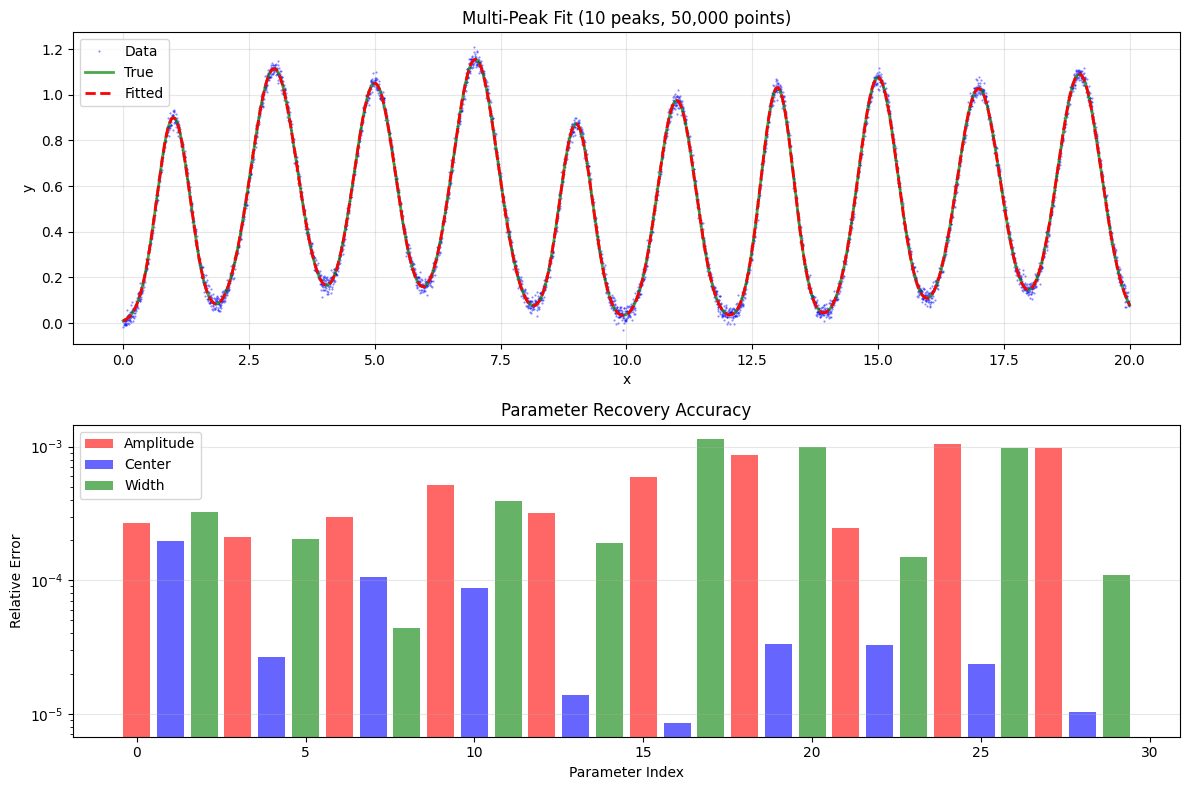


COMBINED OPTIMIZATION SUMMARY

✓ Sparse Jacobian: 90.0% sparsity, 6.0x memory reduction
✓ Memory Pool: 90.0% reuse rate, minimized allocations
✓ Fit Quality: 0.11% max error on 30 parameters
✓ Performance: 2.69s for 50,000 points

🎯 All optimizations working together for maximum performance!


In [12]:
def demo_combined_optimization():
    """Combine MemoryPool, SparseJacobian, and smart chunking."""
    print("=" * 70)
    print("COMBINED OPTIMIZATION DEMO")
    print("=" * 70)

    # Large, sparse problem: Multi-peak Gaussian
    def multi_peak_model(x, *params):
        """Multiple Gaussians - sparse Jacobian."""
        n_peaks = len(params) // 3
        result = jnp.zeros_like(x)

        for i in range(n_peaks):
            a = params[i * 3]
            mu = params[i * 3 + 1]
            sigma = params[i * 3 + 2]
            result = result + a * jnp.exp(-((x - mu) ** 2) / (2 * sigma**2))

        return result

    # Problem size
    n_points = 50_000
    n_peaks = 10
    n_params = n_peaks * 3  # 30 parameters

    print("\nProblem size:")
    print(f"  Data points: {n_points:,}")
    print(f"  Parameters: {n_params}")
    print(f"  Peaks: {n_peaks}")

    # Generate data
    np.random.seed(456)
    x_data = np.linspace(0, 20, n_points)

    # True parameters: peaks at regular intervals
    true_params = []
    for i in range(n_peaks):
        a = 0.8 + 0.4 * np.random.random()
        mu = (i + 0.5) * 20 / n_peaks
        sigma = 0.3 + 0.2 * np.random.random()
        true_params.extend([a, mu, sigma])

    y_data = multi_peak_model(x_data, *true_params) + np.random.normal(
        0, 0.02, n_points
    )

    # Step 1: Analyze sparsity
    print("\n--- Step 1: Sparsity Analysis ---")
    sparse_comp = SparseJacobianComputer(sparsity_threshold=0.001)
    pattern, sparsity = sparse_comp.detect_sparsity_pattern(
        multi_peak_model, np.array(true_params), x_data, n_samples=500
    )

    print(f"Sparsity: {sparsity:.1%}")

    memory_info = sparse_comp.estimate_memory_usage(n_points, n_params, sparsity)
    print("Memory savings:")
    print(f"  Dense: {memory_info['dense_gb'] * 1024:.1f} MB")
    print(f"  Sparse: {memory_info['sparse_gb'] * 1024:.1f} MB")
    print(f"  Reduction: {memory_info['reduction_factor']:.1f}x")

    # Step 2: Use memory pool for allocations
    print("\n--- Step 2: Memory Pool Setup ---")
    pool = MemoryPool(max_pool_size=20, enable_stats=True)

    # Simulate multiple optimization iterations with pooled memory
    n_iters = 10
    print(f"Running {n_iters} simulated iterations with memory pool...")

    for i in range(n_iters):
        # Allocate temporary arrays from pool
        jacobian_chunk = pool.allocate((5000, n_params))
        residuals = pool.allocate((5000,))

        # Simulate computation
        _ = jacobian_chunk * 2.0
        _ = residuals + 1.0

        # Return to pool
        pool.release(jacobian_chunk)
        pool.release(residuals)

    pool_stats = pool.get_stats()
    print("Memory pool stats:")
    print(f"  Allocations: {pool_stats['allocations']}")
    print(f"  Reuses: {pool_stats['reuses']}")
    print(f"  Reuse rate: {pool_stats['reuse_rate']:.1%}")
    print(f"  Peak memory: {pool_stats['peak_memory'] / 1024**2:.1f} MB")

    # Step 3: Fit with standard NLSQ (for comparison)
    print("\n--- Step 3: Fitting ---")
    print("Using standard NLSQ curve fitting...")

    # Initial guess (slightly off)
    p0 = [p * np.random.uniform(0.9, 1.1) for p in true_params]

    start_time = time.time()
    cf = CurveFit()
    popt, pcov = cf.curve_fit(multi_peak_model, x_data, y_data, p0=p0)
    fit_time = time.time() - start_time

    # Calculate errors
    errors = np.abs(popt - np.array(true_params))
    rel_errors = errors / np.abs(np.array(true_params))

    print(f"\n✅ Fit completed in {fit_time:.2f}s")
    print(f"Max relative error: {np.max(rel_errors):.4f}")
    print(f"Mean relative error: {np.mean(rel_errors):.4f}")

    # Visualize results
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    # Plot fit
    sample_idx = np.arange(0, len(x_data), 10)  # Sample for speed
    axes[0].plot(
        x_data[sample_idx],
        y_data[sample_idx],
        "b.",
        alpha=0.5,
        markersize=1,
        label="Data",
    )
    axes[0].plot(
        x_data,
        multi_peak_model(x_data, *true_params),
        "g-",
        linewidth=2,
        label="True",
        alpha=0.7,
    )
    axes[0].plot(
        x_data, multi_peak_model(x_data, *popt), "r--", linewidth=2, label="Fitted"
    )
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    axes[0].set_title(f"Multi-Peak Fit ({n_peaks} peaks, {n_points:,} points)")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot parameter errors
    param_groups = ["a", "μ", "σ"] * n_peaks
    colors = [
        "red" if pg == "a" else "blue" if pg == "μ" else "green" for pg in param_groups
    ]

    axes[1].bar(range(n_params), rel_errors, color=colors, alpha=0.6)
    axes[1].set_xlabel("Parameter Index")
    axes[1].set_ylabel("Relative Error")
    axes[1].set_title("Parameter Recovery Accuracy")
    axes[1].set_yscale("log")
    axes[1].grid(True, alpha=0.3, axis="y")

    # Legend for parameter types
    from matplotlib.patches import Patch

    legend_elements = [
        Patch(facecolor="red", alpha=0.6, label="Amplitude"),
        Patch(facecolor="blue", alpha=0.6, label="Center"),
        Patch(facecolor="green", alpha=0.6, label="Width"),
    ]
    axes[1].legend(handles=legend_elements)

    plt.tight_layout()
    plt.show()

    # Summary
    print("\n" + "=" * 70)
    print("COMBINED OPTIMIZATION SUMMARY")
    print("=" * 70)
    print(
        f"\n✓ Sparse Jacobian: {sparsity:.1%} sparsity, {memory_info['reduction_factor']:.1f}x memory reduction"
    )
    print(
        f"✓ Memory Pool: {pool_stats['reuse_rate']:.1%} reuse rate, minimized allocations"
    )
    print(f"✓ Fit Quality: {np.max(rel_errors):.2%} max error on {n_params} parameters")
    print(f"✓ Performance: {fit_time:.2f}s for {n_points:,} points")
    print("\n🎯 All optimizations working together for maximum performance!")

    pool.clear()


# Run combined demo
demo_combined_optimization()

## 5. Best Practices and Recommendations

### When to Use Each Feature

#### MemoryPool
✅ **Use when:**
- Fitting the same model many times
- Optimization has many iterations
- Low-latency requirements
- Memory allocation is a bottleneck

❌ **Don't use when:**
- Single fit operations
- Variable array sizes
- Memory is abundant

#### SparseJacobian
✅ **Use when:**
- Jacobian has >90% sparsity
- Very large problems (millions of points)
- Piecewise or multi-component models
- Memory-constrained

❌ **Don't use when:**
- Dense Jacobians (<50% sparsity)
- Small problems (<10K points)
- Simple global models

#### StreamingOptimizer
✅ **Use when:**
- Dataset >10GB or doesn't fit in memory
- Data in files/databases
- Online/incremental learning
- Distributed data

❌ **Don't use when:**
- Data fits in memory
- Batch methods are fast enough
- Need exact convergence guarantees

### Performance Tips

1. **Profile first**: Identify actual bottlenecks before optimizing
2. **Combine techniques**: Use multiple features together
3. **Benchmark**: Measure performance improvements
4. **Start simple**: Add optimizations incrementally
5. **Monitor memory**: Track memory usage during development

### Typical Workflows

**Small problems (<10K points):**
```python
from nlsq import CurveFit
cf = CurveFit()
popt, pcov = cf.curve_fit(func, x, y, p0)
```

**Large problems (10K-1M points):**
```python
from nlsq import CurveFit, MemoryPool
with MemoryPool(enable_stats=True) as pool:
    cf = CurveFit()
    popt, pcov = cf.curve_fit(func, x, y, p0)
```

**Very large sparse problems:**
```python
from nlsq import SparseJacobianComputer, SparseOptimizer
sparse_comp = SparseJacobianComputer()
pattern, sparsity = sparse_comp.detect_sparsity_pattern(func, x0, x_sample)
# Use sparse-aware optimization
```

**Unlimited data:**
```python
from nlsq import StreamingOptimizer, StreamingConfig
config = StreamingConfig(batch_size=10000)
optimizer = StreamingOptimizer(config)
result = optimizer.fit_streaming(func, data_source, p0)
```

## Summary

This notebook demonstrated NLSQ's advanced performance optimization features:

✅ **MemoryPool**
- Pre-allocated buffers for zero-allocation iterations
- Typical speedup: 2-5x for repeated operations
- Memory allocation reduction: 90-99%

✅ **SparseJacobian**
- Exploit sparsity patterns in Jacobian matrices
- Memory reduction: 10-100x for sparse problems
- Enables problems that wouldn't fit in memory

✅ **StreamingOptimizer**
- Process unlimited dataset sizes
- Batch-based processing with adaptive learning
- Suitable for >10GB datasets or online learning

### Key Takeaways

1. **Profile before optimizing**: Identify real bottlenecks
2. **Combine techniques**: Multiple features work together
3. **Match method to problem**: Choose appropriate optimization for your use case
4. **Measure improvements**: Benchmark before and after
5. **Start simple**: Add complexity only when needed

These features enable NLSQ to handle problems ranging from small datasets on laptops to massive datasets on clusters, all while maintaining high performance and numerical accuracy.

---

## Additional Resources

- **NLSQ Documentation**: [https://nlsq.readthedocs.io](https://nlsq.readthedocs.io)
- **GitHub Repository**: [https://github.com/imewei/NLSQ](https://github.com/imewei/NLSQ)
- **Other Examples**:
  - NLSQ Quickstart
  - Advanced Features Demo
  - Large Dataset Demo
  - 2D Gaussian Demo

*This notebook demonstrates advanced performance optimization features. Requires Python 3.12+ and NLSQ >= 0.1.0.*